### Import

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
plt.style.use('dark_background')

### Transform

In [16]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),])

### Load data and loaders

In [17]:
train_data = torchvision.datasets.MNIST(root='./data/', train=True, download=False, transform=transform)
train_data, val_data = torch.utils.data.random_split(train_data, [48000, 12000])
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False, num_workers=2)



### Visualize data

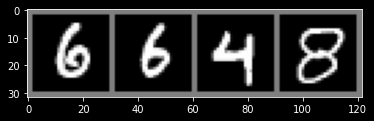

In [18]:
#Function to show some random images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#Get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

#Show images
imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))



### Define model

In [19]:
class cnn_model(nn.Module):

    def __init__(self, num_classes: int = 1000) -> None:
        super(cnn_model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 32, kernel_size=2, stride=1, padding=0),
            nn.ReLU(inplace=True)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
        )

    def convforward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        return x
    def classifierForward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.classifier(x)
        return x

### Check device and init with lr=1e-6

In [20]:
if torch.cuda.is_available():
    print("Running on GPU")
    device = 'cuda:0'
else:
    print("Running on CPU")
    device = 'cpu'
cnn = cnn_model(num_classes=10)
cnn.to(device)

#Loss
criterion = nn.CrossEntropyLoss()

#Optimizer(SGD)
optimizer = optim.SGD(cnn.parameters(), lr=1e-6, momentum=0.9)

epochs = 1

Running on GPU


In [21]:
import gc
torch.cuda.empty_cache()
#del variables
gc.collect()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  111927 KB |  146838 KB |  451790 MB |  451680 MB |\n|       from large pool |  104448 KB |  139264 KB |  408102 MB |  408000 MB |\n|       from small pool |    7479 KB |    8654 KB |   43688 MB |   43680 MB |\n|---------------------------------------------------------------------------|\n| Active memory         |  111927 KB |  146838 KB |  451790 MB |  451680 MB |\n|       from large pool |  104448 KB |  139264 KB |

### Training and validation

In [22]:
# set writer for tensorboard
writer = SummaryWriter()
epoch_data = []
train_epoch = []
val_epoch = []
features = []
allLabels = []
for epoch in range(epochs):  # loop over the dataset multiple times
    epoch_data.append(epoch + 1)
    running_loss = 0.0
    running_loss_val = 0.0
    for i, data in enumerate(trainloader, 0):
        print('\rProgress for training: [{}/{}] Epoch progrss: [{}/{}]'.format(epoch+1, epochs, i+1, len(trainloader)), end='', flush=True)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        feat = cnn.convforward(inputs)
        if epoch == epochs-1:
            f = feat.cpu()
            features.append(f)
            allLabels.append(labels)
        output = cnn.classifierForward(feat)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        writer.add_scalar("Loss/train_pretrained", loss, epoch)
        # print statistics
        running_loss += loss.item() / len(trainloader)
    for i, data in enumerate(val_loader,0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # forward only
        feat = cnn.convforward(inputs)
        output = cnn.classifierForward(feat)
        loss = criterion(output, labels)

        # print statistics
        running_loss_val += loss.item() / len(val_loader)
    train_epoch.append(running_loss)
    val_epoch.append(running_loss_val)
    

print('\nFinished Training of CNN')
writer.flush()
writer.close()

Progress for training: [1/1] Epoch progrss: [12000/12000]
Finished Training of CNN


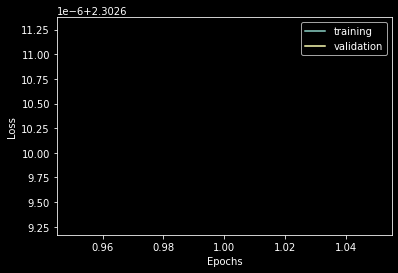

In [23]:
plt.plot(range(1,epochs+1), train_epoch,label='training')
plt.plot(range(1,epochs+1),val_epoch, label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing

In [24]:
#Testing Accuracy
correct = 0
total = 0
with torch.no_grad():
    for i, data in enumerate(testloader):
        print('\rTesting progrss: [{}/{}]'.format(i+1, len(testloader)), end='', flush=True)

        images, labels = data[0].to(device), data[1].to(device)
        feat = cnn.convforward(images)
        output = cnn.classifierForward(feat)
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('\nAccuracy of the network on the test images: {}%'.format(
    100.0 * correct / total))

Testing progrss: [2500/2500]
Accuracy of the network on the test images: 10.14%


### Now we have to convert to numpy array and format correctly....

In [25]:
allFeatures = []
# each feature in features contains 4 samples since batche_size = 4
print(len(features)*4)
for batch in features:
    for f in batch:
        allFeatures.append(torch.flatten(f).detach().numpy())

print(len(allFeatures))

48000
48000


In [26]:
labels = []
# each feature in features contains 4 samples since batche_size = 4
print(len(allLabels)*4)
for batch in allLabels:
    for f in batch:
        f = torch.flatten(f.cpu()).detach().numpy()
        labels.append(f.item())
print(len(labels))

48000
48000


### Plot cool graphs

Progress: [10/10]
Building plot...


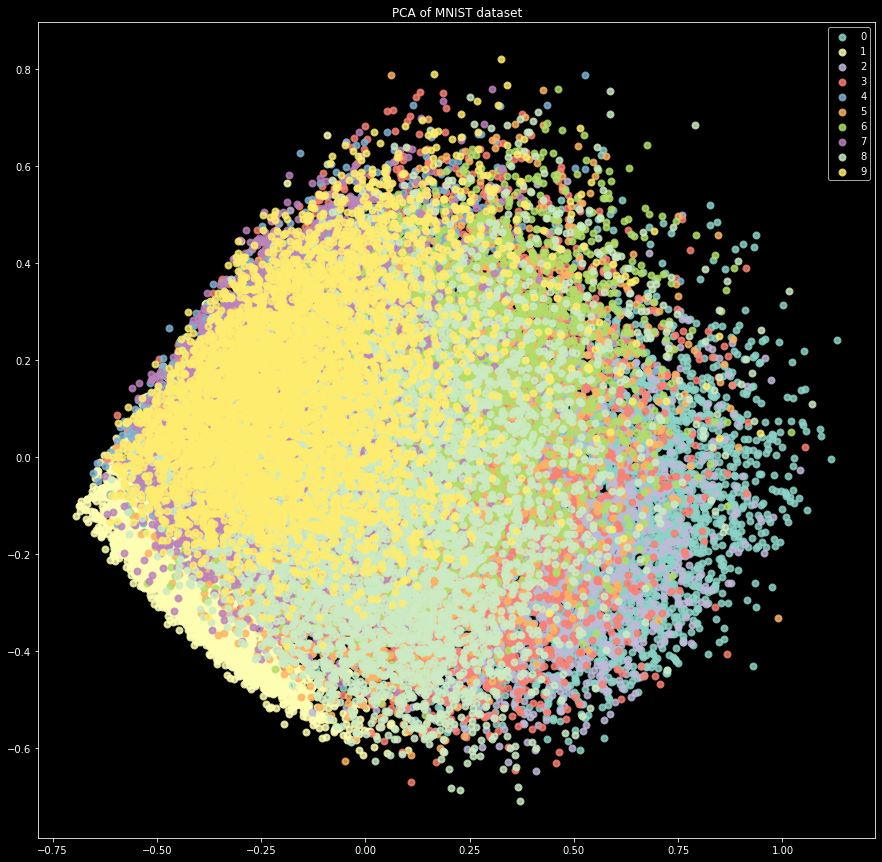

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(allFeatures).transform(allFeatures)
targets = np.unique(labels)

plt.figure(figsize=(15,15))
lw = 2
for j,i in enumerate(targets):
    print('\rProgress: [{}/{}]'.format(j+1, len(targets)), end='', flush=True)
    plt.scatter(pca[labels == i, 0], 
                pca[labels == i, 1],
                alpha=.8, lw=lw,
                label=targets[i])
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of MNIST dataset')
print("\nBuilding plot...")
plt.show()

Embedding features...
Embedding Complete
Progress: [10/10]
Building plot...


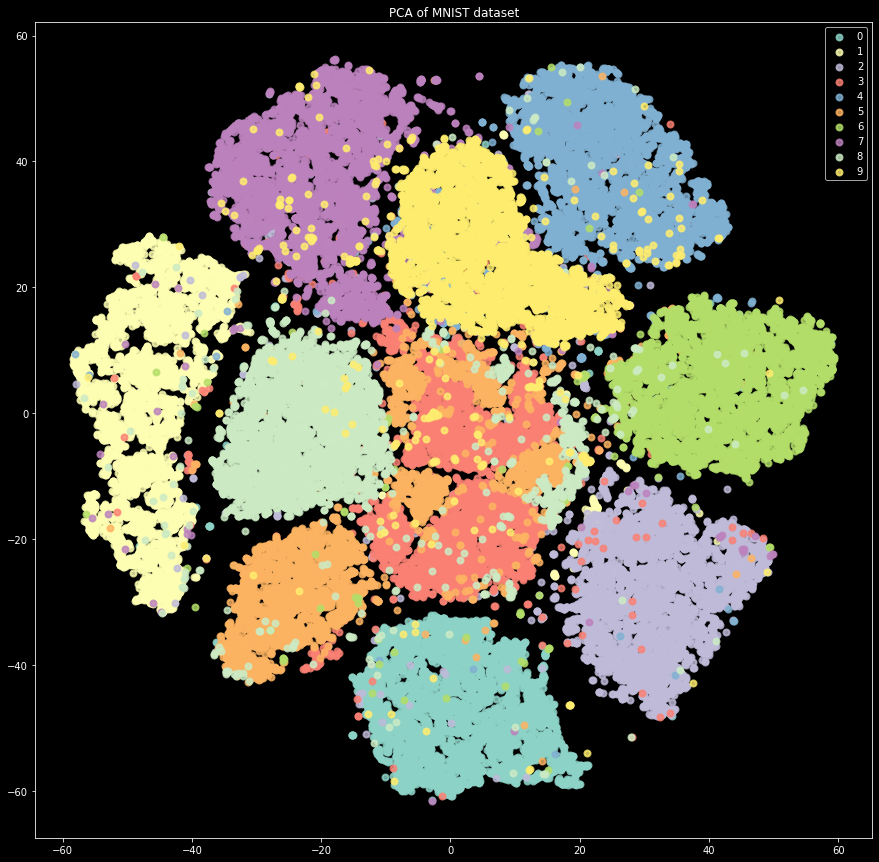

In [29]:
from sklearn.manifold import TSNE
print("Embedding features...")
tsne_embedded = TSNE(n_components=2).fit_transform(allFeatures)
print("Embedding Complete")
tsne_embedded.shape

targets = np.unique(labels)

plt.figure(figsize=(15,15))
lw = 2
for j,i in enumerate(targets):
    print('\rProgress: [{}/{}]'.format(j+1, len(targets)), end='', flush=True)
    plt.scatter(tsne_embedded[labels == i, 0], 
                tsne_embedded[labels == i, 1],
                alpha=.8, lw=lw,
                label=targets[i])
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of MNIST dataset')
print("\nBuilding plot...")
plt.show()